In [1]:
%pip install transformers
%pip install datasets
%pip install peft
%pip install bitsandbytes
%pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
import torch
from tqdm import tqdm
from datasets import Dataset
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import AutoPeftModelForCausalLM
from transformers import pipeline
from transformers import BitsAndBytesConfig
import sentencepiece
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/CS182/CS\ 182\ Final\ Project

/content/drive/.shortcut-targets-by-id/1hzhdcGA40OipfzF0SRT7omKvzCSi0q4r/CS 182 Final Project


In [5]:
def read_files(base_path: str, file_names: list):
  dfs = []
  for file in file_names:
    temp_df = pd.read_csv(f"./{base_path}/{file}")
    temp_df["class"] = file.split(".")[0]
    dfs.append(temp_df)
  df = pd.concat(dfs)
  df.columns = ["question", "answer", "class"]
  return df

test_df = read_files("Data Processing/Test data", ["126.csv", "127.csv", "182.csv", "189_fa.csv", "189_sp.csv"])
test_dataset = Dataset.from_pandas(test_df)
test_dataset

Dataset({
    features: ['question', 'answer', 'class', '__index_level_0__'],
    num_rows: 409
})

In [6]:
def get_test_ppl(model, tokenizer, dataset, exp_name, base_model=False, device='cuda'):

  nlls = []

  for example in tqdm(dataset):
    q = example['question']
    a = example['answer']

    if not base_model:
      q = '<s>[INST] ' + q + ' [/INST]'
      a = a + ' </s>'

    qa = q + ' ' + a
    q_encoding_length = tokenizer(q, return_tensors="pt").input_ids.shape[1]
    qa_encoding = tokenizer(qa, return_tensors='pt')
    input_ids = qa_encoding.input_ids
    target_ids = input_ids.clone()
    target_ids[:, :q_encoding_length] = -100

    with torch.no_grad():
      output = model(input_ids.to(device), labels=target_ids.to(device))
      nlls.append(output.loss.item())

  df = pd.DataFrame(dataset)
  df['nll'] = nlls
  df['ppl'] = torch.exp(torch.tensor(nlls))
  df = df[['class', 'question', 'answer', 'nll', 'ppl']]
  # df.to_csv(f'./Data Processing/Test data/results_gpt2_medium/{exp_name}.csv', index=False)
  return df

### Experiment-specific arguments

In [7]:
ranks = [4, 8, 32, 64, 128]
alphas = [16, 32, 64, 128, 256]
prefix = "Model/Geovanni/"
runs = {}
rank_runs = {}
alpha_runs = {}
for rank in ranks:
  rank_runs[f"gpt2_r{rank}_a16_final"] = prefix + f"gpt2_lora_r{rank}_a16_lr2e-4/gpt2_lora_r{rank}_a16"
  # runs[f"gpt2_r{rank}_a16_epoch3"] = prefix + f"llama_lora_r{rank}_a16/results/checkpoint-350"

for alpha in alphas:
  alpha_runs[f"gpt2_r64_a{alpha}_final"] = prefix + f"gpt2_lora_r64_a{alpha}_lr2e-4/gpt2_lora_r64_a{alpha}"
  # runs[f"gpt2_r64_a{alpha}_epoch3"] = prefix + f"llama_lora_r64_a{alpha}/results/checkpoint-350"

runs["rank"] = rank_runs
runs["alpha"] = alpha_runs

In [8]:
device = "cuda"
base_model = True
base_model_id = "gpt2-medium"

use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
run_perp = []
for run in rank_runs:
  model = AutoPeftModelForCausalLM.from_pretrained(rank_runs[run]).to(device)
  model.config.use_cache = False
  model.config.pretraining_tp = 1
  df = get_test_ppl(model, tokenizer, test_dataset, run, base_model, device)
  print(f"{run}: {df['ppl'].mean()}")
  run_perp.append(df['ppl'].mean())
  del model

alpha_perp = []
for run in alpha_runs:
  model = AutoPeftModelForCausalLM.from_pretrained(alpha_runs[run]).to(device)
  model.config.use_cache = False
  model.config.pretraining_tp = 1
  df = get_test_ppl(model, tokenizer, test_dataset, run, base_model, device)
  print(f"{run}: {df['ppl'].mean()}")
  alpha_perp.append(df['ppl'].mean())
  del model

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

100%|██████████| 409/409 [00:25<00:00, 15.83it/s]


gpt2_r4_a16_final: 9.958474159240723


100%|██████████| 409/409 [00:24<00:00, 16.46it/s]


gpt2_r8_a16_final: 9.88219928741455


100%|██████████| 409/409 [00:24<00:00, 16.77it/s]


gpt2_r32_a16_final: 9.847829818725586


100%|██████████| 409/409 [00:25<00:00, 16.26it/s]


gpt2_r64_a16_final: 9.808427810668945


100%|██████████| 409/409 [00:25<00:00, 16.23it/s]


gpt2_r128_a16_final: 9.779725074768066


100%|██████████| 409/409 [00:24<00:00, 16.59it/s]


gpt2_r64_a16_final: 9.808427810668945


100%|██████████| 409/409 [00:24<00:00, 16.45it/s]


gpt2_r64_a32_final: 9.660361289978027


100%|██████████| 409/409 [00:25<00:00, 16.35it/s]


gpt2_r64_a64_final: 9.44774341583252


100%|██████████| 409/409 [00:24<00:00, 16.43it/s]


gpt2_r64_a128_final: 9.173747062683105


100%|██████████| 409/409 [00:25<00:00, 16.29it/s]


gpt2_r64_a256_final: 8.948579788208008


In [ ]:
ranks = [4, 8, 32, 64, 128]
alphas = [16, 32, 64, 128, 256]
prefix = "Model/mir/"
llama_runs = {}
llama_rank_runs = {}
llama_e3_rank_runs = {}
llama_alpha_runs = {}
llama_e3_alpha_runs = {}
for rank in ranks:
  llama_rank_runs[f"llama_r{rank}_a16_final"] = prefix + f"llama_lora_r{rank}_a16/llama_3b_v2_lora_r{rank}_a16"
  llama_e3_rank_runs[f"llama_r{rank}_a16_epoch3"] = prefix + f"llama_lora_r{rank}_a16/results/checkpoint-350"

for alpha in alphas:
  llama_alpha_runs[f"llama_r64_a{alpha}_final"] = prefix + f"llama_lora_r64_a{alpha}/llama_3b_v2_lora_r64_a{alpha}"
  llama_e3_alpha_runs[f"llama_r64_a{alpha}_epoch3"] = prefix + f"llama_lora_r64_a{alpha}/results/checkpoint-350"

llama_runs["rank"] = rank_runs
llama_runs["alpha"] = alpha_runs

In [ ]:
device = "cuda"
base_model = True
base_model_id = "openlm-research/open_llama_3b_v2"

use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/512k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
llama_run_perp = []
for run in llama_rank_runs:
  model = AutoPeftModelForCausalLM.from_pretrained(llama_rank_runs[run]).to(device)
  model.config.use_cache = False
  model.config.pretraining_tp = 1
  df = get_test_ppl(model, tokenizer, test_dataset, run, base_model, device)
  print(f"{run}: {df['ppl'].mean()}")
  llama_run_perp.append(df['ppl'].mean())
  del model

llama_alpha_perp = []
for run in llama_alpha_runs:
  model = AutoPeftModelForCausalLM.from_pretrained(llama_alpha_runs[run]).to(device)
  model.config.use_cache = False
  model.config.pretraining_tp = 1
  df = get_test_ppl(model, tokenizer, test_dataset, run, base_model, device)
  print(f"{run}: {df['ppl'].mean()}")
  llama_alpha_perp.append(df['ppl'].mean())
  del model

config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

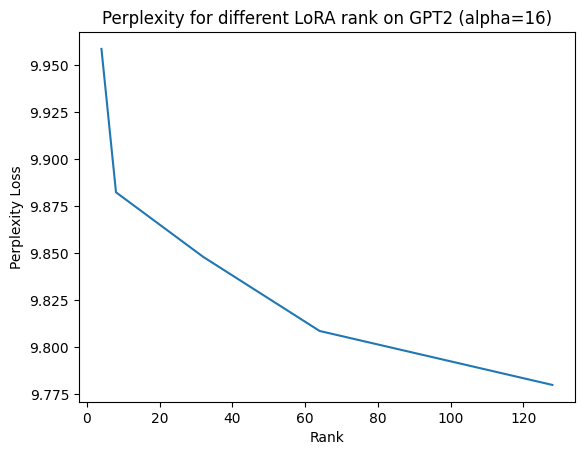

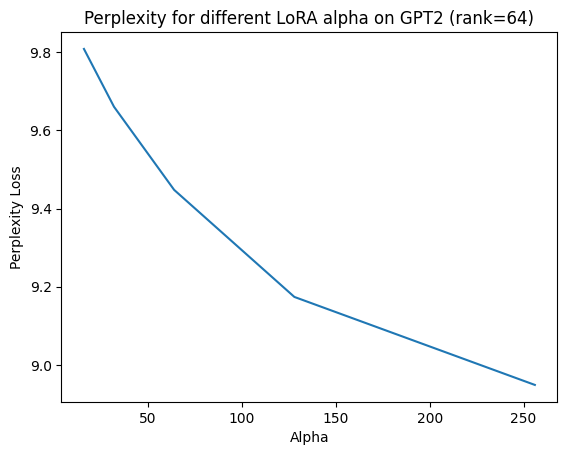

In [ ]:
# plt.figure(figsize=(10, 4), dpi=200)
# plt.subplot(1, 2, 1)
plt.title("Perplexity for different LoRA rank on GPT2 (alpha=16)")
plt.xlabel("Rank")
plt.ylabel("Perplexity Loss")
plt.plot(ranks, run_perp)
plt.show()

# plt.subplot(1, 2, 2)
plt.title("Perplexity for different LoRA alpha on GPT2 (rank=64)")
plt.xlabel("Alpha")
plt.ylabel("Perplexity Loss")
plt.plot(alphas, alpha_perp)
plt.show()

In [ ]:
# base model
model = AutoModelForCausalLM.from_pretrained("gpt2-medium").to(device)
model.config.use_cache = False
model.config.pretraining_tp = 1
df = get_test_ppl(model, tokenizer, test_dataset, "gpt2_medium_base", base_model=True, device=device)
print(f"gpt2_medium: {df['ppl'].mean()}")

100%|██████████| 409/409 [00:22<00:00, 18.35it/s]

gpt2_medium: 10.98373031616211


### Generate responses

In [ ]:
humaneval_df = read_files("Data Processing/Human Eval Data", ["126.csv", "127.csv", "182.csv", "189_fa.csv", "189_sp.csv"])
inputs = humaneval_df['question'].apply(lambda x: f"<s>[INST] {x} [/INST] ").to_list()
humaneval_df

,question,answer,class
0,Explain why entropy is always a non-negative q...,Entropy is non-negative because it is defined ...,126
1,Explain the Gram-Schmidt process and how it is...,The Gram-Schmidt process is an algorithm used ...,126
2,How do you compute the expected time until all...,To compute the expected time until all 20 ligh...,126
3,How is the joint probability mass function (PM...,"For discrete random variables $X$ and $Y$, the...",126
4,Summarize the relationship between reversibili...,"Within the context of Markov chains, a reversi...",126
...,...,...,...
6,What is the relationship between the primal an...,"In Kernel Ridge Regression, the primal weight ...",189_sp
7,Explain the concept of Kernel Perceptrons and ...,"In a Kernel Perceptron algorithm, the weights ...",189_sp
8,Explain the concept of using nonlinearity in n...,Nonlinearity in neural networks is introduced ...,189_sp
9,Explain why the naive computation of gradients...,The naive computation of gradients is ineffici...,189_sp


In [ ]:
# fine-tuned model
model = AutoPeftModelForCausalLM.from_pretrained("Model/Geovanni/gpt2_lora_r64_a256_lr2e-4/gpt2_lora_r64_a256").to(device)
pipe_tuned = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200, device=device)
results_tuned = pipe_tuned(inputs)
results_tuned = [result[0]['generated_text'] for result in results_tuned]
humaneval_df_tuned = humaneval_df.copy()
humaneval_df_tuned['output'] = results_tuned
humaneval_df_tuned.to_csv("Data Processing/Human Eval Data/results/gpt2_lora_r64_a256.csv", index=False)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartFo

In [ ]:
# base model
model = AutoModelForCausalLM.from_pretrained("gpt2-medium").to(device)
pipe_base = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200, device=device)
results_base = pipe_base(inputs)
results_base = [result[0]['generated_text'] for result in results_base]
humaneval_df_base = humaneval_df.copy()
humaneval_df_base['output'] = results_base
humaneval_df_base.to_csv("Data Processing/Human Eval Data/results/gpt2_medium_base.csv", index=False)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene